### Transport algorithm to calculate upwelled water (and tracer) 

Define shelf boundary and calculate volume of water transported onto the shelf through cells with $C_i \ge C_s$

In [3]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [211]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [4]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def find_NoCShelf_ind(hfacNoC):
    '''Find x,y,z indices of the no-canyon shelf
       hfacNoc is HFacC (or S or W) from the no canyon bathymetry (nz,ny,nx)
       RETURNS:
       Array of z-indices of the shelf bottom, size (ny,nx)
       '''
    
    BottomInd = np.argmax(hfacNoC[:,:,:]<1.0,axis=0) # start looking for first land cell from the surface down.
    return (BottomInd)

In [5]:
sns.set_context('notebook')
sns.set_style('white')

### Barkley linear stratification

In [9]:
Grid = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc' 
with Dataset(Grid, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    Y = nbl.variables['Y'][:]
    X = nbl.variables['X'][:]
    hFac = nbl.variables['HFacC'][:]
    Depth = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFac, 0)
    maskC = np.ma.getmask(hfac)
    rA = nbl.variables['rA'][:]
    dxg = nbl.variables['dxG'][:]
    drf = nbl.variables['drF'][:]
    Zf = nbl.variables['RF'][:]
GridNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc' 
with Dataset(GridNoC, 'r') as nbl:
    Znoc = nbl.variables['RC'][:]
    Ynoc = nbl.variables['Y'][:]
    Xnoc = nbl.variables['X'][:]
    hFacnoc = nbl.variables['HFacC'][:]
    Depthnoc = nbl.variables['Depth'][:]
    hfacnoc = np.ma.masked_values(hFacnoc, 0)
    maskCnoc = np.ma.getmask(hfacnoc)
    rAv = nbl.variables['rA'][:]

State = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc' 
StateNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/stateGlob.nc' 
st = xr.open_dataset(State)

Ptracer = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc' 
ptr = xr.open_dataset(Ptracer)


In [14]:
x_slice = slice(0,616)
x_slice_vert = slice(129,231)
y_slice_vert = slice(120,240)
z_slice = slice(0,80)
z_slice_zoom = slice(0,40)
y_ind = 129 # sb index
z_ind = 29 # sb index

/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


4.979555725159372
3.416477238291776


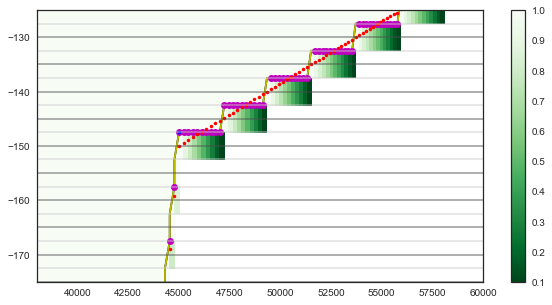

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,5), sharey=True)
pc = ax.pcolormesh(Y,Z,hfac[:,:,100], cmap='Greens_r')
plt.colorbar(pc)

ax.contour(Y,Z,maskC[:,:,100],levels=[0],colors=['k'])
ax.contour(Y,Z,maskCnoc[:,:,100],levels=[0],colors=['y'])
ax.contour(Y,Z,maskC[:,:,180],levels=[0],colors=['k'])

sh_bot = find_NoCShelf_ind(hfacnoc)

ax.plot(Y,Z[sh_bot[:,100]], 'mo')

ax.plot(Y,-Depth[:,100],'r.')
ax.set_ylim(-175,-125)
ax.set_xlim(38000,60000)
ax.plot(Y[129],Z[29],'.b')
for dep in Z:
    ax.axhline(dep, color='0.8', alpha=0.5)
for dep in Zf:
    ax.axhline(dep, color='0.3', alpha=0.5)

#cell thickness at tracer point
th_sh = hfac[29,129,100]*drf[29]
print(th_sh)
th_other = hfac[29,132,100]*drf[29]
print(th_other)



In [12]:
# fig, ax = plt.subplots(1,1,figsize=(10,5), sharey=True)

# WW = np.empty_like(sh_bot[y_slice_vert,x_slice_vert])
# for ii in range(np.shape(sh_bot[y_slice_vert,x_slice_vert])[1]):
#     print( '%d out of %d' %(ii, np.shape(sh_bot[y_slice_vert,x_slice_vert])[1]))
#     for jj in range(np.shape(sh_bot[y_slice_vert,x_slice_vert])[0]):
#         WW[jj,ii] = st.W[16,sh_bot[jj,ii],jj,ii]

    
# pc = ax.pcolormesh(X[x_slice_vert],Y[y_slice_vert],WW,y_slice_vert,x_slice_vert,
#                    cmap=cmo.cm.balance)
# plt.colorbar(pc)
# ax.contour(X[x_slice_vert],Y[y_slice_vert],maskC[z_ind+1,y_slice_vert,x_slice_vert],levels=[1],colors=['k'])
# # ax.plot(Y,-Depth[:,100],'r.')
# ax.set_ylim(47000,52500)
# ax.set_xlim(56000,65000)
# for xx in X[x_slice_vert]:
#      ax.axvline(xx, color='0.8', alpha=0.5)
# for yy in Y[y_slice_vert]:
#      ax.axhline(yy, color='0.8', alpha=0.5)

# # #cell thickness at tracer point
# # th_sh = hfac[29,129,100]*drf[29]
# # print(th_sh)
# # th_other = hfac[29,132,100]*drf[29]
# # print(th_other)

Tracer 01 concentration at day 6.0 at shelf break cross-section and shelf-break depth horizontal section.
 Masked values have C<C_s=7.2 uM


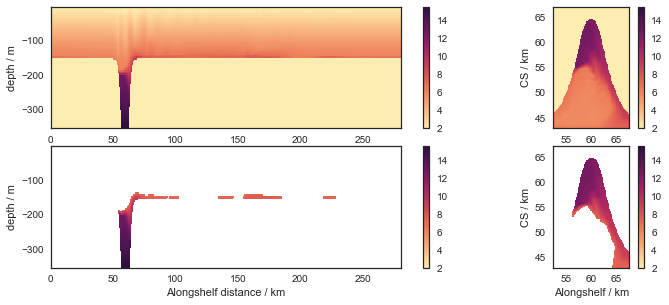

In [16]:
tt = 12
bgcolor = '#8b7765'

f = plt.figure(figsize = (11,4.8))
gs = gspec.GridSpec(1, 2, width_ratios=[1,0.4], wspace = 0.0)
gs1 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],hspace=0.15,wspace=0.1,height_ratios=[1,1])
gs2 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1],hspace=0.15,wspace=0.1,height_ratios=[1,1])

ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])
ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])

#ax1.set_facecolor(bgcolor)
#ax2.set_facecolor(bgcolor)
#ax3.set_facecolor(bgcolor)
#ax0.set_facecolor(bgcolor)

Cs = ptr.Tr01[0,z_ind,50,180]
Cmax = ptr.Tr01[0,62,50,180]
Cmin = ptr.Tr01[0,0,50,180]

Tr_masked = ptr.Tr01[tt,:62,y_ind,:]#np.ma.masked_array(ptr.Tr01[tt,:62,y_ind,:],mask=maskC[:62, y_ind,:])

pc0 = ax0.pcolormesh(X/1000,Z[:62],Tr_masked, cmap=cmo.cm.matter, vmax=Cmax, vmin = Cmin)
pc1 = ax1.pcolormesh(X/1000,Z[:62],np.ma.masked_less(Tr_masked, Cs), 
                     cmap=cmo.cm.matter, vmax=Cmax, vmin = Cmin)
plt.colorbar(pc0, ax=ax0)
plt.colorbar(pc1, ax=ax1)
ax0.set_ylabel('depth / m')
ax1.set_ylabel('depth / m')
ax1.set_xlabel('Alongshelf distance / km')

Tr_masked_v = ptr.Tr01[tt,z_ind+1,y_slice_vert,x_slice_vert]#np.ma.masked_array(ptr.Tr01[tt,z_ind,y_slice_vert,x_slice_vert],mask=maskC[z_ind,y_slice_vert, x_slice_vert])

pc2 = ax2.pcolormesh(X[x_slice_vert]/1000,Y[y_slice_vert]/1000,
                     Tr_masked_v,
                     cmap=cmo.cm.matter, vmax=Cmax, vmin = Cmin)
plt.colorbar(pc2, ax=ax2)
pc3 = ax3.pcolormesh(X[x_slice_vert]/1000,Y[y_slice_vert]/1000,
                     np.ma.masked_less(Tr_masked_v, Cs), 
                     cmap=cmo.cm.matter, vmax=Cmax, vmin = Cmin)
plt.colorbar(pc3, ax=ax3)

mask_cs = np.ma.getmask(np.ma.masked_less(ptr.Tr01[tt,:62,y_ind,:], Cs))
mask_vert = np.ma.getmask(np.ma.masked_less(ptr.Tr01[tt,z_ind+1,y_slice_vert,x_slice_vert], Cs))

ax3.set_xlabel('Alongshelf / km')
ax2.set_ylabel('CS / km')
ax3.set_ylabel('CS / km')

ax2.set_aspect(1)
ax3.set_aspect(1)

print('Tracer 01 concentration at day %1.1f at shelf break cross-section and shelf-break depth horizontal section.\n Masked values have C<C_s=%1.1f uM' %(tt/2, Cs))

V, W at day 8.0 at shelf break cross-section and shelf-break depth horizontal section. 
 Masked values have C<C_s=7.2 uM


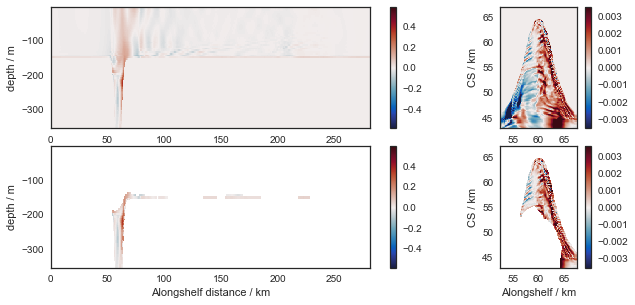

In [17]:
tt = 16
f = plt.figure(figsize = (10,4.8))
gs = gspec.GridSpec(1, 2, width_ratios=[1,0.4], wspace=0)
gs1 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],hspace=0.15,wspace=0.15,height_ratios=[1,1])
gs2 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1],hspace=0.15,wspace=0.15,height_ratios=[1,1])

ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])
ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])

Vmax = np.max(st.V[10,:,:,:])
Vmin = -Vmax #np.min(st.V[10,:,:,:])
Wmax = np.max(st.W[10,62,:,:])
Wmin = -Wmax#np.min(st.W[10,:,:,:])

V = st.V.isel(T = tt,Z=slice(0,62))
V = np.add(V[..., :-1, :], V[..., 1:, :]) / 2
V_masked = V[:,y_ind,:]#np.ma.masked_array(V[:,y_ind,:],mask=maskC[:62, y_ind,:])

pc0 = ax0.pcolormesh(X/1000,Z[:62],V_masked, cmap=cmo.cm.balance, vmax=Vmax, vmin = Vmin)
pc1 = ax1.pcolormesh(X/1000,Z[:62],np.ma.masked_array(V_masked, mask = mask_cs),
               cmap=cmo.cm.balance, vmax=Vmax, vmin = Vmin)
plt.colorbar(pc0, ax=ax0)
plt.colorbar(pc1, ax=ax1)
ax0.set_ylabel('depth / m')
ax1.set_ylabel('depth / m')
ax1.set_xlabel('Alongshelf distance / km')

W_masked = st.W[tt,z_ind+1,y_slice_vert,x_slice_vert]#np.ma.masked_array(st.W[tt,z_ind,y_slice_vert,x_slice_vert],mask=maskC[z_ind, y_slice_vert, x_slice_vert])

pc2 = ax2.pcolormesh(X[x_slice_vert]/1000,Y[y_slice_vert]/1000,W_masked,
               cmap=cmo.cm.balance, vmax = Wmax, vmin = Wmin)
pc3 = ax3.pcolormesh(X[x_slice_vert]/1000,Y[y_slice_vert]/1000,
               np.ma.masked_array(W_masked, mask=mask_vert), 
               cmap=cmo.cm.balance, vmax = Wmax, vmin = Wmin)
plt.colorbar(pc2, ax=ax2)
plt.colorbar(pc3, ax=ax3)
ax3.set_xlabel('Alongshelf / km')
ax2.set_ylabel('CS / km')
ax3.set_ylabel('CS / km')

ax2.set_aspect(1)
ax3.set_aspect(1)

print('V, W at day %1.1f at shelf break cross-section and shelf-break depth horizontal section. \n Masked values have C<C_s=%1.1f uM' %(tt/2, Cs))

**Algorithm**

In [18]:
y_ind = 129
z_ind = 29
x_st = 180
y_st = 50

Cs = ptr.Tr01[0,z_ind,y_st,x_st]
tt = slice(0,19)

# Mask using Cs criterion 
mask_exp = mpt.maskExpand(maskC[:z_ind+1,:,:],ptr.Tr01[tt,:z_ind+1,:,:])
Tr_masked = ptr.Tr01[tt,:z_ind+1,y_ind,:]#np.ma.masked_array(ptr.Tr01[tt,:z_ind+1,y_ind,:],mask=mask_exp[tt,:z_ind+1,y_ind,:])
Tr_masked_v = ptr.Tr01[tt,z_ind,y_slice_vert,x_slice_vert]#np.ma.masked_array(ptr.Tr01[tt,z_ind,y_slice_vert,x_slice_vert],
                                 #mask=mask_exp[tt,z_ind,y_slice_vert, x_slice_vert])
# Get tracer mask
mask_cs = np.ma.getmask(np.ma.masked_less(ptr.Tr01[tt,:z_ind+1,y_ind,:], Cs))
mask_vert = np.ma.getmask(np.ma.masked_less(ptr.Tr01[tt,z_ind,y_slice_vert,x_slice_vert], Cs))

# Get V and unstagger
V = st.V.isel(T = tt, Z=slice(0,z_ind+1))
V = np.add(V[..., :-1, :], V[..., 1:, :]) / 2
V_masked = V[...,y_ind,:]#np.ma.masked_array(V[...,y_ind,:],mask=mask_exp[tt,:, y_ind,:])

# Apply tracer mask to unstaggered V
V_upw = np.ma.masked_array(V_masked, mask = mask_cs)

# Calculate transport
drf_exp = np.expand_dims(np.expand_dims(drf[:z_ind+1],1),0)
drf_exp = drf_exp + np.zeros(mask_cs.shape)

dxg_exp = np.expand_dims(np.expand_dims(dxg[y_ind,:],0),0)
dxg_exp = dxg_exp + np.zeros(mask_cs.shape)

hfac_exp = mpt.maskExpand(hfac[:z_ind+1,y_ind,:],mask_cs)
wat = drf_exp*dxg_exp*hfac_exp*V_upw

# Apply land mask to W 
W_masked = st.W[tt,z_ind,y_slice_vert,x_slice_vert]#np.ma.masked_array(st.W[tt,z_ind,y_slice_vert,x_slice_vert],
                              #mask=mask_exp[tt,z_ind,y_slice_vert,x_slice_vert])

# Apply tracer mask to land-masked W
rA_exp = np.expand_dims(rA[y_slice_vert,x_slice_vert], 0)
rA_exp = rA_exp + np.zeros(np.shape(W_masked))
W_upw = np.ma.masked_array(W_masked*rA_exp, mask=mask_vert)

Mean upwelling flux days 4-9 is 7.86e+04 m^3s^{-1} \pm 4.40e+03
previous algorithm counted 1.03878E5 m^3s^-1
Scaling estimates 1.1E5 m^3s^-1


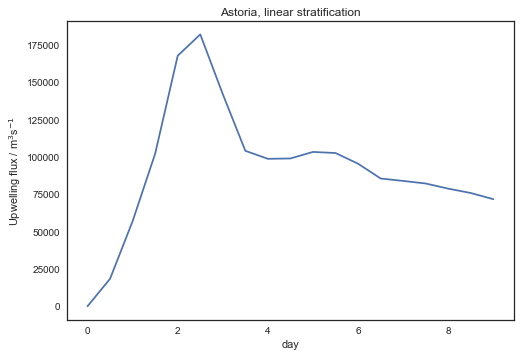

In [20]:
phi = np.sum(np.sum(wat,axis=1),axis=1)+np.sum(np.sum(W_upw,axis=1),axis=1)
plt.plot(np.arange(np.shape(phi)[0])/2,phi)
plt.xlabel('day')
plt.ylabel('Upwelling flux / m$^3$s$^{-1}$')
plt.title('Astoria, linear stratification')
print('Mean upwelling flux days 4-9 is %1.2e m^3s^{-1} \pm %1.2e' %(np.mean(phi[14:]),np.std(phi[14:])))
print('previous algorithm counted 1.03878E5 m^3s^-1')
print('Scaling estimates 1.1E5 m^3s^-1')